# Libraries

In [2]:
import tensorflow as tf
import gym
import numpy as np
from stable_baselines import DQN #type: ignore
from copy import deepcopy
import math
from gym.spaces import Discrete, Dict, Box
from gym import spaces
from random import seed
import random 
from gym import Env
from datetime import datetime
import sys
import time
import pickle
import stable_baselines
import sklearn
from sklearn import tree , svm 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB , CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix #type: ignore
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from itertools import product
from sklearn.utils import resample
from sklearn.model_selection import KFold , RepeatedKFold
from sklearn.metrics import f1_score
from sklearn import impute
import statistics
from scipy import stats
from copy import deepcopy
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from math import ceil
import copy
import sys
from sklearn.metrics import jaccard_score
import time
import multiprocessing
from pymoo.algorithms.nsga2 import calc_crowding_distance
sys.path.append('lib/')
import subprocess
import logging
from sklearn.utils import shuffle
import csv
from csv import reader
import os
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score
from tqdm import tqdm


class StoreWrapper(gym.Wrapper):
  ''''
  :param env: (gym.Env) Gym environment that will be wrapped
  :param max_steps: (int) Max number of steps per episode
  '''
  def __init__(self, env):
    # Call the parent constructor, so we can access self.env later
    super(StoreWrapper, self).__init__(env)
    self.max_steps = 200
    # Counter of steps per episode
    self.current_step = 0
    self.mem = []
    self.TotalReward = 0.0 
    self.env = env
    self.first_state = 0
    self.first_obs = 0
    self.prev_obs = 0 
    self.states_list = []
    self.info = {}
  
  def reset(self):
    """
    Reset the environment 
    """
    # Reset the counter
    self.current_step = 0
    obs =self.env.reset()
    self.TotalReward = 0.0
    self.first_obs = obs
    return obs

  def step(self, action):
    """
    In this function we store the initial state as well as the memory of the agent
    :param action: ([float] or int) Action taken by the agent
    :return: (np.ndarray, float, bool, dict) observation, reward, is the episode over?, additional informations
    """
    if self.current_step == 0: #store initial state
      self.prev_obs = self.first_obs
      self.first_state = deepcopy(self.env)
      self.states_list.append(self.first_state)
    self.current_step += 1
    obs, reward, done, info = self.env.step(action)
    self.TotalReward += reward
    self.mem.append(tuple((self.prev_obs,action)))
    self.prev_obs = obs
    if self.current_step >= self.max_steps:
      done = True
      # Update the info dict to signal that the limit was exceeded
    if done:
      self.mem.append(tuple(('done',self.TotalReward)))
    self.info['mem'] = self.mem
    self.info['state'] = self.states_list
    # self.mem.append(tuple(obs,action))
    return obs, reward, done, info

  def set_state(self, state):
    """
    :param state: initial state of the episode
    :return: environment is updated and observations is returned
    """
    self.env = deepcopy(state)
    obs = np.array(list(self.env.unwrapped.state))
    self.current_step = 0
    self.TotalReward = 0.0
    self.first_obs = obs
    return obs

def abstract_state(model,state1,d):
  if type(state1) == str:
    if state1 == 'done':
      return 'end'
  q_value1 = model.step_model.step([state1])
  return( ceil(q_value1[1][0][0]/d), ceil(q_value1[1][0][1]/d))

def abstract_state_general(model,state1,d):
  if type(state1) == str:
    if state1 == 'done':
      return 'end'
  q_values = model.step_model.step([state1])
  return tuple([ceil(q_value/d) for q_value in q_values[1][0]])

def Abstract_classes(ep,abstraction_d,model):
  d=abstraction_d
  abs_states1=[]
  for episode in ep:
    for state,action in episode:
      abs_st = abstract_state(model,state,d)
      if abs_st == 'end':
        continue
      abs_states1.append(abs_st)
  unique1=list(set(abs_states1))
  uni1 = np.array(unique1)
  a=len(abs_states1)
  b=len(set(abs_states1))
  print("abstract states:",b)
  print("Concrete states",a)
  print("ratio",b/a)
  return unique1,uni1

def is_functional_fault(episode,epsilon):
  for state, _ in episode:
    if type(state) == str:
      if state == 'done':
        return False
    if abs(state[0]) >= (2.4-epsilon):
      return True
  # no functional fault is obsereved
  return False

def is_reward_fault(episode,threshold):
  last_state = episode[-1]
  assert last_state[0] == 'done'
  if last_state[1] < threshold:
    return True
  else:
    return False

def ML_first_representation_func_based(Abs_d,functional_func,reward_func,model,input_episodes,unique1,epsilon,threshold):
  """
  TO-DO : fix epsilon and threshold
  """
  d = Abs_d
  data1_x_b=[]
  data1_y_b= [] 
  data1_y_f_b = []
  for i, episode in enumerate(input_episodes):
    record = np.zeros(len(unique1))
    temp_flag = False
    for state, action in episode:
      ab = abstract_state(model,state,d)
      if ab == 'end':
        assert not temp_flag, f'Episode data problem, two terminations in one episode. Episode number{i}'
        temp_flag = True
        # print(action)
        # print(functional_func(episode))
        if functional_func(episode,epsilon):
          data1_y_f_b.append(1)
        else:
          data1_y_f_b.append(0)
        if reward_func(episode,threshold):
          data1_y_b.append(1)
        else:
          data1_y_b.append(0)
        # print("end\n\n\n")
        # print(len(data1_y_b),"len(input_episodes)",len(input_episodes))
        continue
        # print(state[0])
      ind = unique1.index(ab)
      record[ind] = 1
      # print(state, action)
      assert len(data1_y_b)<len(input_episodes), "assert"
      # if you want the frequency go with the next line 
      # record[ind] += 1
    data1_x_b.append(record)

  return data1_x_b, data1_y_b, data1_y_f_b


def ML_first_representation(Abs_d,epsilon_functional_fault_boarder,model,ep,unique1):
  d = Abs_d
  # epsilon = 0.05
  epsilon = epsilon_functional_fault_boarder
  data1_x_b=[]
  data1_y_b= [] 
  data1_y_f_b = []
  functional_fault = False
  reward_fault_threshold = 70
  for episode in ep:
    record = np.zeros(len(unique1))
    for state, action in episode:
      ab = abstract_state(model,state,d)
      if ab == 'end':
        # print(action)
        if functional_fault:
          data1_y_f_b.append(1)
        else:
          data1_y_f_b.append(0)
        if action >= reward_fault_threshold:
          data1_y_b.append(0)
        else:
          data1_y_b.append(1)
        functional_fault=False
        continue
      if abs(state[0]) >= (2.4-epsilon) :
        functional_fault = True
      ind = unique1.index(ab)
      # if len(w[0])>1:
        # print('error len is greater than 1')
      record[ind] = 1
      # if you want the frequency go with the next line 
      # record[ind] += 1
    data1_x_b.append(record)

  return data1_x_b, data1_y_b, data1_y_f_b

#report function to check the performance metrics of the model
def report(model2,x_train, y_train,x_test, y_test):
  print("********************** reporting the result of the model **************************")
  print('The score for train data is {0}'.format(model2.score(x_train,y_train)))
  print('The score for test data is {0}'.format(model2.score(x_test,y_test)))


  predictions_train = model2.predict(x_train)
  predictions_test = model2.predict(x_test)

  print("\n\n--------------------------------------recall---------------------------------")

  print('the test recall for the class yes is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=1)))
  print('the test recall for the class no is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=0)))

  print('the training recall for the class yes is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=1)))
  print('the training recall for the class no is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=0)))


  print("\n\n--------------------------------------precision------------------------------")


  print('the test precision for the class yes is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=1)))
  print('the test precision for the class no is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=0)))

  print('the training precision for the class yes is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=1)))
  print('the training precision for the class no is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=0)))

  print("\n\n")
  print(classification_report(y_test, predictions_test, target_names=['NO ','yes']))

  tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
  specificity = tn / (tn+fp)
  print("\n\nspecifity :",specificity)
  print("\n\n--------------------------------------confusion----------------------------")
  CM = metrics.confusion_matrix(y_test, predictions_test)
  print("The confusion Matrix:")
  print(CM)
  print('the accuracy score in {0}\n\n'.format(accuracy_score(y_test, predictions_test)))
  print("********************** plotting the confusion matrix & ROC curve **************************")
  plot_confusion_matrix(model2, x_test, y_test) #type: ignore
  metrics.plot_roc_curve(model2, x_test, y_test)  #type: ignore
  plt.show()



def random_test_2(model, env, Num):
  obs=env.reset()
  counter = 1
  episode_reward = 0.0
  end =-1
  lastpoint = -1
  for i in range(Num):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    if done:
      counter += 1
      end = i
      episode_reward = 0.0
      obs = env.reset()
  iter = deepcopy(counter)
  u=1
  while iter>1:
    if env.info['mem'][-u][0]=='done': 
      lastpoint = -u
      iter -= 1
    u+=1
  assert lastpoint != -1
  assert end != -1
  fin =Num - end
  start = -Num -counter
  randomtest = env.info['mem'][lastpoint:-fin] 
  ran_state = env.info['state'][(-counter+1):-1] 
  return randomtest , ran_state

def fix_testing(testing_episodes,testing_states,Env2):
  # TO DO: fix data typr for if condition change to nparray
  buffer =[] 
  episodes_set = []
  j=0
  for i in range(len(testing_episodes)):
    if testing_episodes[i][0] == 'done':
      if i == 0:
        continue
      buffer.append(testing_episodes[i])
      episodes_set.append(buffer)
      buffer=[]
    else:
      buffer.append(testing_episodes[i])
  if not (np.array(episodes_set[0][0][0])== np.array(Env2.set_state(testing_states[0]),dtype="float32")).all():
    del testing_states[0]
  if not (np.array(episodes_set[0][0][0])==np.array(Env2.set_state(testing_states[0]),dtype="float32")).all():
    assert False, 'problem in starting states'
  if len(episodes_set)!=len(testing_states):
    del testing_states[-1]
  if len(episodes_set)!=len(testing_states):
    assert False, 'problem in data prepration'
  return episodes_set , testing_states





# function Plot

In [18]:
from scipy import stats

def translator(episode,model, d, unique5):
  """
  thid function takes the concrete episodes and returns the encoded episodes 
  based on the presence and absence of the individuals  
  :param 'episode': input episode
  :param 'model': RL model
  :param 'd': abstraction level = 1
  :param 'unique5': abstract classes 
  :return: encoded episodse based on the presence and absence

  """
  d=d
  record = np.zeros(len(unique5))
  for state, action in episode:
    ab = abstract_state(model,state,d)
    if ab == 'end':
      continue
    if ab in unique5:
      ind = unique5.index(ab)
      record[ind] = 1
  return [record]

def episode_player(episodes,d, abs_classes, model, monitor) -> list:
  ''' This function replays the episodes and returns the risk of each step in each episode
  :param 'episodes': input episodes
  :param 'd': abstraction level 
  :param 'abs_classes': abstract classes
  :param 'model': RL model
  :param 'monitor': ML model
  :return: risk of each step in each episode
  
  '''
  episodes_risk=[]
  for episode in episodes:
    risk_array=[]
    for step in range(len(episode)-1):
      monitoring_data = translator(episode[:step],model,d,abs_classes)
      Risk = monitor.predict_proba(monitoring_data)
      risk_array.append(Risk[0][1])
    episodes_risk.append(risk_array)
  return episodes_risk

def single_episode_player(episode,d, abs_classes, model, monitor) -> list:
  ''' This function replays one episodes and returns the risk of each step in episode
  :param 'episode': input episode
  :param 'd': abstraction level
  :param 'abs_classes': abstract classes
  :param 'model': RL model
  :param 'monitor': ML model
  :return: risk of each step in episode
  '''
  risk_array=[]
  for step in range(len(episode)-1):
    monitoring_data = translator(episode[:step],model,d,abs_classes)
    Risk = monitor.predict_proba(monitoring_data)
    risk_array.append(Risk[0][1])
  return risk_array

def position_extractor(episode):
    position =[]
    for i in range(len(episode)-1):
        position.append(episode[i][0][0])
    return position
    
def velocity_extractor(episode):
    velocity =[]
    for i in range(len(episode)-1):
        velocity.append(episode[i][0][1])
    return velocity
def angle_extractor(episode):
    angle =[]
    for i in range(len(episode)-1):
        angle.append(episode[i][0][2])
    return angle
def angular_v_extractor(episode):
    angular_v =[]
    for i in range(len(episode)-1):
        angular_v.append(episode[i][0][3])
    return angular_v


def Plot_all(data,abstraction_level,unique1,RL_model,Monitor,save=False,show=True,data_chunk=0,path='C:/Users/Student/Desktop/vs_git/HazardDetection/CartPole/Plots_CartPole'):
    '''plot risk and position snd velocity in one figure with 3 subplots
    '''
    ## TODO: write a function to return the setteings of the environment and the model

    fig, axs = plt.subplots(5,figsize=(20, 18))
    for i in range(len(data)):
        axs[0].plot([i for i in range(len(data[i])-1)], single_episode_player(data[i],abstraction_level,unique1,RL_model,Monitor), label = f"Episode {i}")
        axs[1].plot([i for i in range(len(data[i])-1)], position_extractor(data[i]), label = f"Episode {i}")
        axs[2].plot([i for i in range(len(data[i])-1)], velocity_extractor(data[i]), label = f"Episode {i}")
        axs[3].plot([i for i in range(len(data[i])-1)], angle_extractor(data[i]), label = f"Episode {i}")
        axs[4].plot([i for i in range(len(data[i])-1)], angular_v_extractor(data[i]) ,label = f"Episode {i}")
    axs[0].legend()
    #plot title and labels
    axs[0].set_title('Risk')
    axs[1].legend()
    axs[1].set_title('Position')
    axs[2].set_title('Velocity')
    axs[3].set_title('Angle')
    axs[4].set_title('Angular Velocity')
    axs[2].legend()
    axs[3].legend()
    axs[4].legend()
    #set range of y axis
    axs[0].set_ylim(-0.1, 1.1)
    
    current_time = datetime.now()
    ID = current_time.strftime("%Y%m%d%H%M%S")
    if save:
        fig.savefig(f'{path}/RPVAA2_C{data_chunk}_{ID}.png')
    #close the plot
    plt.close()

def translate_episode_steps(episode,HD_model,translator,d,abs_classes):
    translated_episode = []
    for i in range(len(episode)-1):
        translated_episode.append(translator(episode[:i],HD_model,d,abs_classes))
    return translated_episode

def translate_multiple_episodes_steps(episodes,HD_model,translator,d,abs_classes):
    translated_episodes = []
    for episode in episodes:
        translated_buffer = []
        for i in range(len(episode)-1):
            translated_buffer.append(translator(episode[:i],HD_model,d,abs_classes))
        translated_episodes.append(translated_buffer)
    return translated_episodes



def Forest_CI_multiple(translated_episodes,HD_model,chunk,abs_d,path = 'CartPole/temp'):
    '''
    size of translated_episodes is limited by the number of colors available for one plot
    '''
    plt.figure(figsize=(20, 12))
    results_Arr=[]
    r_arr=[]
    E=0
    colors = ['red','blue','green','yellow','black','purple','orange','pink','brown','grey','cyan','magenta','lime','olive','teal','navy','maroon','violet','turquoise','salmon','gold','coral','indigo','crimson','azure','beige','chocolate','lavender','plum','orchid','tan','khaki','wheat','silver','sienna','peru','peachpuff','papayawhip','mistyrose','moccasin','lemonchiffon','lawngreen','lightgreen','limegreen']
    for translated_episode , plt_color in zip(translated_episodes,colors[:len(translated_episodes)]):
        E+=1
        num_time_steps = len(translated_episode) # Number of time steps
        num_trees = HD_model.n_estimators
        predictions = np.zeros((num_time_steps, num_trees))
        for i, tree in enumerate(HD_model.estimators_):
            for j in range(len(translated_episode)):
                Risk = tree.predict_proba(translated_episode[j])[0][1]
                predictions[j, i] = Risk
        # Calculate the mean prediction for each time step
        mean_predictions = np.mean(predictions, axis=1)

        # Calculate the standard deviation for each time step
        std_predictions = np.std(predictions, axis=1)

        # Calculate the lower and upper bounds for the confidence intervals
        confidence_level = 0.95 # Change as needed
        z_score = stats.norm.ppf((1 + confidence_level) / 2)
        lower_bounds = mean_predictions - z_score * std_predictions / np.sqrt(num_trees)
        upper_bounds = mean_predictions + z_score * std_predictions / np.sqrt(num_trees)
        difference = upper_bounds - lower_bounds
        # Store the results in a dataframe
        results = pd.DataFrame({
            'Mean prediction': mean_predictions,
            'Lower bound': lower_bounds,
            'Upper bound': upper_bounds
        })
        # Save the results to a file
        results_Arr.append(results)
        r_arr.append([mean_predictions, lower_bounds, upper_bounds,difference])
        plt.fill_between(range(num_time_steps), lower_bounds, upper_bounds, color=plt_color, alpha=0.2)
        plt.plot(mean_predictions, color=plt_color, label=f'Episode {E}')
        # set the y axis limits
        plt.ylim(-0.1, 1.1)
        # Add labels and title to the plot
        plt.xlabel('Time step')
        plt.ylabel('Prediction')
        plt.title('Confidence Intervals of Random Forest Predictions')
    # results_arr.append(r_arr)
    # Save the plot as a file
    current_time = datetime.now()
    ID = current_time.strftime("%Y%m%d%H%M%S")
    
    plt.legend()
    plt.savefig(f'{path}/confidence_intervals_{chunk}_{ID}.png', bbox_inches='tight')
    # np.array(results_Arr).to_csv('confidence_intervals.csv', index=False)
    # save results_arr to pickle file
    plt.close()
    pickle_path = f'CI/Abs_{abs_d}'
    if not os.path.exists(pickle_path):
        os.makedirs(pickle_path)
    with open(f'{pickle_path}/results_arr_{chunk}.pkl', 'wb') as f:
        pickle.dump(r_arr, f)




    


In [19]:

def ACCURACY(translated_episodes,HD_model,chunk,abs_d,path='Data/Pred'):
    '''
    size of translated_episodes is limited by the number of colors available for one plot
    '''
    # plt.figure(figsize=(20, 12))
    results_Arr=[]
    r_arr=[]
    E=0
    RF_pred=[]
    # translated_episodes = translate_multiple_episodes_steps(episode,RL_model,translator,d,unique1)
    # colors = ['red','blue','green','yellow','black','purple','orange','pink','brown','grey','cyan','magenta','lime','olive'\
    # ,'teal','navy','maroon','violet','turquoise','salmon','gold','coral','indigo','crimson','azure','beige','chocolate',\
    # 'lavender','plum','orchid','tan','khaki','wheat','silver','sienna','peru','peachpuff','papayawhip','mistyrose','moccasin','lemonchiffon','lawngreen','lightgreen','limegreen']
    for translated_episode in tqdm(translated_episodes, desc=f'extracting risk for episodes'):
        RF_pred_E=[]
        E+=1
        num_time_steps = len(translated_episode) # Number of time steps
        num_trees = HD_model.n_estimators
        predictions = np.zeros((num_time_steps, num_trees))
        for j in range(len(translated_episode)):
            RF_pred_E.append(HD_model.predict_proba(translated_episode[j])[0][1])
            for i, tree in enumerate(HD_model.estimators_):
                Risk = tree.predict_proba(translated_episode[j])[0][1]
                predictions[j, i] = Risk
        # Calculate the mean prediction for each time step
        mean_predictions = np.mean(predictions, axis=1)
            
        # Calculate the standard deviation for each time step
        std_predictions = np.std(predictions, axis=1)

        # Calculate the lower and upper bounds for the confidence intervals
        confidence_level = 0.95 # Change as needed
        z_score = stats.norm.ppf((1 + confidence_level) / 2)
        lower_bounds = mean_predictions - z_score * std_predictions / np.sqrt(num_trees)
        upper_bounds = mean_predictions + z_score * std_predictions / np.sqrt(num_trees)
        difference = upper_bounds - lower_bounds
        # Store the results in a dataframe
        results = pd.DataFrame({
            'Mean prediction': mean_predictions,
            'Lower bound': lower_bounds,
            'Upper bound': upper_bounds
        })
        # Save the results to a file
        results_Arr.append(results)
        r_arr.append([mean_predictions, lower_bounds, upper_bounds,difference])
        # plt.fill_between(range(num_time_steps), lower_bounds, upper_bounds, color=plt_color, alpha=0.2)
        RF_pred.append(RF_pred_E)
    # results_arr.append(r_arr)
    # Save the plot as a file
    return RF_pred

def ACCURACY_lowerbound(translated_episodes,HD_model,chunk,abs_d,path='Data/Pred'):
    '''
    size of translated_episodes is limited by the number of colors available for one plot
    '''
    # plt.figure(figsize=(20, 12))
    results_Arr=[]
    r_arr=[]
    E=0
    RF_pred=[]
    LB = []
    # translated_episodes = translate_multiple_episodes_steps(episode,RL_model,translator,d,unique1)
    # colors = ['red','blue','green','yellow','black','purple','orange','pink','brown','grey','cyan','magenta','lime','olive'\
    # ,'teal','navy','maroon','violet','turquoise','salmon','gold','coral','indigo','crimson','azure','beige','chocolate',\
    # 'lavender','plum','orchid','tan','khaki','wheat','silver','sienna','peru','peachpuff','papayawhip','mistyrose','moccasin','lemonchiffon','lawngreen','lightgreen','limegreen']
    for translated_episode in tqdm(translated_episodes, desc=f'extracting risk for episodes'):
        RF_pred_E=[]
        E+=1
        num_time_steps = len(translated_episode) # Number of time steps
        num_trees = HD_model.n_estimators
        predictions = np.zeros((num_time_steps, num_trees))
        for j in range(len(translated_episode)):
            RF_pred_E.append(HD_model.predict_proba(translated_episode[j])[0][1])
            for i, tree in enumerate(HD_model.estimators_):
                Risk = tree.predict_proba(translated_episode[j])[0][1]
                predictions[j, i] = Risk
        # Calculate the mean prediction for each time step
        mean_predictions = np.mean(predictions, axis=1)
            
        # Calculate the standard deviation for each time step
        std_predictions = np.std(predictions, axis=1)

        # Calculate the lower and upper bounds for the confidence intervals
        confidence_level = 0.95 # Change as needed
        z_score = stats.norm.ppf((1 + confidence_level) / 2)
        lower_bounds = mean_predictions - z_score * std_predictions / np.sqrt(num_trees)
        upper_bounds = mean_predictions + z_score * std_predictions / np.sqrt(num_trees)
        difference = upper_bounds - lower_bounds
        # Store the results in a dataframe
        results = pd.DataFrame({
            'Mean prediction': mean_predictions,
            'Lower bound': lower_bounds,
            'Upper bound': upper_bounds
        })
        # Save the results to a file
        results_Arr.append(results)
        r_arr.append([mean_predictions, lower_bounds, upper_bounds,difference])
        # plt.fill_between(range(num_time_steps), lower_bounds, upper_bounds, color=plt_color, alpha=0.2)
        RF_pred.append(RF_pred_E)
        LB.append(list(lower_bounds))
    # results_arr.append(r_arr)
    # Save the plot as a file
    return RF_pred , LB

def ACCURACY_LU_bounds(translated_episodes,HD_model,chunk,abs_d,path='Data/Pred'):
    '''
    size of translated_episodes is limited by the number of colors available for one plot
    '''
    # plt.figure(figsize=(20, 12))
    results_Arr=[]
    r_arr=[]
    E=0
    RF_pred=[]
    LB = []
    UB = []
    # translated_episodes = translate_multiple_episodes_steps(episode,RL_model,translator,d,unique1)
    # colors = ['red','blue','green','yellow','black','purple','orange','pink','brown','grey','cyan','magenta','lime','olive'\
    # ,'teal','navy','maroon','violet','turquoise','salmon','gold','coral','indigo','crimson','azure','beige','chocolate',\
    # 'lavender','plum','orchid','tan','khaki','wheat','silver','sienna','peru','peachpuff','papayawhip','mistyrose','moccasin','lemonchiffon','lawngreen','lightgreen','limegreen']
    for translated_episode in tqdm(translated_episodes, desc=f'extracting risk for episodes'):
        RF_pred_E=[]
        E+=1
        num_time_steps = len(translated_episode) # Number of time steps
        num_trees = HD_model.n_estimators
        predictions = np.zeros((num_time_steps, num_trees))
        for j in range(len(translated_episode)):
            RF_pred_E.append(HD_model.predict_proba(translated_episode[j])[0][1])
            for i, tree in enumerate(HD_model.estimators_):
                Risk = tree.predict_proba(translated_episode[j])[0][1]
                predictions[j, i] = Risk
        # Calculate the mean prediction for each time step
        mean_predictions = np.mean(predictions, axis=1)
            
        # Calculate the standard deviation for each time step
        std_predictions = np.std(predictions, axis=1)

        # Calculate the lower and upper bounds for the confidence intervals
        confidence_level = 0.95 # Change as needed
        z_score = stats.norm.ppf((1 + confidence_level) / 2)
        lower_bounds = mean_predictions - z_score * std_predictions / np.sqrt(num_trees)
        upper_bounds = mean_predictions + z_score * std_predictions / np.sqrt(num_trees)
        difference = upper_bounds - lower_bounds
        # Store the results in a dataframe
        results = pd.DataFrame({
            'Mean prediction': mean_predictions,
            'Lower bound': lower_bounds,
            'Upper bound': upper_bounds
        })
        # Save the results to a file
        results_Arr.append(results)
        r_arr.append([mean_predictions, lower_bounds, upper_bounds,difference])
        RF_pred.append(RF_pred_E)
        LB.append(list(lower_bounds))
        UB.append(list(upper_bounds))
    return RF_pred , LB , UB


In [20]:
def extract_weighted_performance(Pred, FRT, T , EPSILON):
    labels = []
    for episode in FRT:
        if is_functional_fault(episode,EPSILON):
            labels.append([1.0 for i in range(len(episode)-1)])
        else:
            labels.append([0.0 for i in range(len(episode)-1)])
    
    accuracy = []
    accuracy_w = []
    precision = []
    recall = []
    f1 = []
    max_len = max([len(i) for i in Pred])
    for i in range(max_len):
        pred_interval = [0 if pred[i]<=T else 1 for pred in Pred if len(pred)>i]
        labels_interval = [label[i] for label in labels if len(label)>i]
        accuracy.append(accuracy_score(labels_interval,pred_interval))
        accuracy_w.append(balanced_accuracy_score(labels_interval, pred_interval))
        precision.append(precision_score(labels_interval, pred_interval, average='weighted'))
        recall.append(recall_score(labels_interval, pred_interval, average='weighted'))
    return [accuracy,accuracy_w, precision, recall]

def extract_weighted_performance_f1(Pred, FRT, T , EPSILON):
    labels = []
    for episode in FRT:
        if is_functional_fault(episode,EPSILON):
            labels.append([1.0 for i in range(len(episode)-1)])
        else:
            labels.append([0.0 for i in range(len(episode)-1)])
    
    accuracy = []
    accuracy_B = []
    # accuracy_w = []
    precision = []
    recall = []
    f1 = []
    f1_m = []
    max_len = max([len(i) for i in Pred])
    for i in range(max_len):
        pred_interval = [0 if pred[i]<=T else 1 for pred in Pred if len(pred)>i]
        labels_interval = [label[i] for label in labels if len(label)>i]
        accuracy.append(accuracy_score(labels_interval,pred_interval))
        accuracy_B.append(balanced_accuracy_score(labels_interval, pred_interval))
        f1.append(f1_score(labels_interval, pred_interval, average='weighted'))
        f1_m.append(f1_score(labels_interval, pred_interval, average='macro'))
        precision.append(precision_score(labels_interval, pred_interval, average='weighted'))
        recall.append(recall_score(labels_interval, pred_interval, average='weighted'))
    return [accuracy,accuracy_B, precision, recall, f1, f1_m]

def extract_weighted_performance_f1_fixed_length(Pred, FRT, T , EPSILON):
    labels = []
    max_len = max([len(i) for i in Pred])
    for episode in FRT:
        if is_functional_fault(episode,EPSILON):
            labels.append([1.0 for i in range(max_len)])
        else:
            labels.append([0.0 for i in range(max_len)])
    # print(max_len)
    accuracy = []
    accuracy_B = []
    # accuracy_w = []
    precision = []
    recall = []
    f1 = []
    f1_m = []
    for i in range(max_len):
        # pred_interval = [0 if pred[i]<=T else 1 for pred in Pred if len(pred)>i]
        # pred_interval is 0 if the probability of the fault is less than T and 1 if the probability of the fault is greater than T and we repead the final value for the rest of the episode
        # pred_interval = [0 if pred[i]<=T else 1 for pred in Pred if len(pred)>i]
        pred_interval = []
        for pred in Pred:
            if len(pred)>i:
                if pred[i]<T:
                    pred_interval.append(0.0)
                else:
                    pred_interval.append(1.0)
            else:
                if pred[-1]<T:
                    pred_interval.append(0.0)
                else:
                    pred_interval.append(1.0)
        labels_interval = [label[i] for label in labels if len(label)>i]
        # print(i)
        # print(len(pred_interval),len(labels_interval))
        accuracy.append(accuracy_score(labels_interval,pred_interval))
        accuracy_B.append(balanced_accuracy_score(labels_interval, pred_interval))
        f1.append(f1_score(labels_interval, pred_interval, average='weighted'))
        f1_m.append(f1_score(labels_interval, pred_interval, average='macro'))
        precision.append(precision_score(labels_interval, pred_interval, average='weighted'))
        recall.append(recall_score(labels_interval, pred_interval, average='weighted'))
    return [accuracy,accuracy_B, precision, recall, f1, f1_m]

def plot_and_save_metrics(metrics_w, save_path):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    accuracy,accuracy_w, precision, recall, f1, f1_m = metrics_w
    axs[0, 0].plot(accuracy)
    axs[0, 0].set_title("Accuracy")
    axs[0, 1].plot(accuracy_w)
    axs[0, 1].set_title("Balanced Accuracy")
    axs[1, 0].plot(precision)
    axs[1, 0].set_title("Precision")
    axs[1, 1].plot(recall)
    axs[1, 1].set_title("Recall")
    axs[2, 0].plot(f1)
    axs[2, 0].set_title("F1_weighted")
    axs[2, 1].plot(f1_m)
    axs[2, 1].set_title("F1_macro")

    plt.suptitle("Metrics Plot")
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.savefig(save_path)
    plt.close()

def translate_multiple_episodes_steps_tqdm(episodes,RL_model,translator,d,abs_classes):
    translated_episodes = []
    for episode in tqdm(episodes,desc=f'translating episodes'):
        translated_buffer = []
        for i in range(len(episode)-1):
            translated_buffer.append(translator(episode[:i],RL_model,d,abs_classes))
        translated_episodes.append(translated_buffer)
    return translated_episodes

# Load RL agent

In [21]:
Dataset_path = "Path to the dataset"

Drive_model  =f"{Dataset_path}/Trained_agent/dqn-168.pkl"


env2 = gym.make('CartPole-v1')
env2 = StoreWrapper(env2)
model = DQN('MlpPolicy',env=env2, verbose=1)
model = model.load(Drive_model)

Loading a model without an environment, this model cannot be trained until it has a valid environment.


# Generate accuracy files and transformed episodes 

In [ ]:
#change d_set to indicate abstraction levels you want to explore
# you will need this files to the next steps to generate the plots

# d_set=[5,4,3,2,1.5,1,0.8,0.5,0.1,0.05,0.01]
# d_set=[2,1.5,1,0.8,0.5,0.1,0.05,0.01]
d_set=[0.11, 0.12,0.14,0.15,0.17] # for example


EPSILON = 0.05
with open(f'{Dataset_path}/Random_episodes/FRT_test_68.pkl', 'rb') as file2:
        FRT = pickle.load(file2)
FRT = FRT[:1000]
for d in d_set:
    print(f'\n\n\n#########################################\nAbstraction level: {d}')
    Read_from_data = True
    if Read_from_data:
        # assert False
        with open(f'{Dataset_path}/ABS/Abstraction_data_final_{d}.pickle', 'rb') as file2:
            unique1 = pickle.load(file2)
        uni1=np.array(unique1)
    else:
        # print('Reading unique1 from file')
        assert False , 'No abstraction data' #remove this line to generate abstraction data
        unique1,uni1 = Abstract_classes(final_episodes,d,model)
        with open(f'{Dataset_path}/ABS/Abstraction_data_final_{d}.pickle', 'wb') as f:
            pickle.dump(unique1, f)

    #########################################################  Read RF_FF_1rep  #############
    HD_model_path1 = f'{Dataset_path}/ML_models'
    HD_model_path = f'{HD_model_path1}/RF_FF_1rep_{d}.pickle'
    with open(HD_model_path, 'rb') as file2:
        RF_FF_1rep = pickle.load(file2)
        
    #########################################################  save episodes and plot accuracy #############
    newpath = f'Plots_CartPole/Accuracy_files/Abs_{d}' #generating files for each abstraction level 
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        
    #########################################################  save episodes #############
    # saving episodes in chunks to avoid memory error
    chunk_size = 200
    start = 0
    end = chunk_size
    while start < len(FRT):
        episode_chunk = translate_multiple_episodes_steps_tqdm(FRT[start:end], model, translator, d, unique1)
        with open(f'{newpath}/episode_chunk_{start}_{end}.pickle', 'wb') as file2:
            pickle.dump(episode_chunk, file2)
        del episode_chunk
        start += chunk_size
        end += chunk_size
        if end > len(FRT):
            end = len(FRT)

    #########################################################  plot accuracy #############
    Pred = []
    LB = []
    UB = []
    chunk_size = 200
    start = 0
    end = chunk_size
    while start < len(FRT):
        #read episodes from pickle
        with open(f'{newpath}/episode_chunk_{start}_{end}.pickle', 'rb') as file2:
            episode_chunk = pickle.load(file2)
        prediction, lowerBound, UpperBound = ACCURACY_LU_bounds(episode_chunk,RF_FF_1rep,50,abs_d=d,path=newpath)
        Pred += prediction
        LB += lowerBound
        UB += UpperBound
        del episode_chunk
        start += chunk_size
        end += chunk_size
        if end > len(FRT):
            end = len(FRT)

    with open(f'{newpath}/Pred.pickle', 'wb') as file2:
        pickle.dump(Pred, file2)
    with open(f'{newpath}/LB.pickle', 'wb') as file2:
        pickle.dump(LB, file2)
    with open(f'{newpath}/UB.pickle', 'wb') as file2:
        pickle.dump(UB, file2)
    met = extract_weighted_performance_f1_fixed_length(Pred, FRT, 0.5, EPSILON)
    #plot metrics and save them
    plot_and_save_metrics(met, f'{newpath}/metrics_with_average_fixedL.png')

    #metrics based on lower bound
    metric2 = extract_weighted_performance_f1_fixed_length(LB, FRT, 0.5, EPSILON)
    #plot metrics and save them
    plot_and_save_metrics(metric2, f'{newpath}/metrics_with_lowerBound_fixedL.png')

    #metrics based on upper bound
    metric3 = extract_weighted_performance_f1_fixed_length(UB, FRT, 0.5, EPSILON)
    #plot metrics and save them
    plot_and_save_metrics(metric3, f'{newpath}/metrics_with_upperBound_fixedL.png')
    

# RQ1

## plot F1 percision and recall in one plot for the optimal abstraction level

In [ ]:

def plot_and_save_metrics_in_one_plot(metrics_Low,metrics_AVG,metrics_high, save_path, meta_data):
    # fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    keys = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_weighted', 'f1_macro']
    metric_low_dict = dict(zip(keys, metrics_Low))
    metric_avg_dict = dict(zip(keys, metrics_AVG))
    metric_high_dict = dict(zip(keys, metrics_high))


    #create figure
    figure = plt.figure(figsize=(8, 4))
    #map x axis from [0,1] to [0,100] percents
    # x = np.linspace(0, 1, len(metric_avg_dict['accuracy'])) * 100
    
    #plot metrics
    plt.plot(metric_avg_dict['precision'], label='Precision')
    plt.plot(metric_avg_dict['recall'], label='Recall')
    # figure.plot(metric_avg_dict['f1_weighted'], label='F1_weighted')
    plt.plot(metric_avg_dict['f1_macro'], label='F1_macro')
    # plt.set_title("Metrics Plot")
    plt.title(f"Performance Metrics Plot")
    # fix legends position to lower right
    plt.legend(loc='lower right')
    # plt.legend()
    # plt.suptitle("Metrics Plot")
    plt.tight_layout()
    # plt.subplots_adjust(top=0.93)
    plt.savefig(save_path,metadata=meta_data)
    plt.close()

In [ ]:
d = 0.11
EPSILON = 0.05
meta_data = {'Author': 'A.zlf', 'Project': 'HD', 'Version': '1',
                 'Description': 'D = Metrics in one graph metrics generated by function plot_combine_in _one .. Cartpole from UB, LB, AVG pickle files(v1)'}
# load Pred, LB, UB from pickle
newpath = f'Plots_CartPole/Accuracy_files/Abs_{d}'
with open(f'{newpath}/Pred.pickle', 'rb') as file2:
    Pred = pickle.load(file2)
with open(f'{newpath}/LB.pickle', 'rb') as file2:
    LB = pickle.load(file2)
with open(f'{newpath}/UB.pickle', 'rb') as file2:
    UB = pickle.load(file2)

metric_A = extract_weighted_performance_f1_fixed_length(Pred, FRT, 0.5, EPSILON)
metric_LB = extract_weighted_performance_f1_fixed_length(LB, FRT, 0.5, EPSILON)
metric_UB = extract_weighted_performance_f1_fixed_length(UB, FRT, 0.5, EPSILON)
plot_and_save_metrics_combined(metric_LB,metric_A,metric_UB,f'RQ_final/Cartpole_D011_{d}_metrics_combined_V1.png',meta_data)


plot_and_save_metrics_in_one_plot(metric_LB,metric_A,metric_UB, f'RQ_final/Cartpole_D011_{d}_metrics_combined_V1.png', Meta_Data)

# RQ2

## Trigerring criteria analysis

In [25]:
def plot_and_save_metrics_combined(metrics_Low,metrics_AVG,metrics_high, save_path, meta_data):
    
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    keys = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_weighted', 'f1_macro']
    metric_low_dict = dict(zip(keys, metrics_Low))
    metric_avg_dict = dict(zip(keys, metrics_AVG))
    metric_high_dict = dict(zip(keys, metrics_high))

    axs[0, 0].plot(metric_low_dict['accuracy'], label='Lower Bound')
    axs[0, 0].plot(metric_avg_dict['accuracy'], label='Average')
    axs[0, 0].plot(metric_high_dict['accuracy'], label='Upper Bound')
    axs[0, 0].set_title("Accuracy")
    axs[0, 0].legend()

    axs[0, 1].plot(metric_low_dict['balanced_accuracy'], label='Lower Bound')
    axs[0, 1].plot(metric_avg_dict['balanced_accuracy'], label='Average')
    axs[0, 1].plot(metric_high_dict['balanced_accuracy'], label='Upper Bound')
    axs[0, 1].set_title("Balanced Accuracy")
    axs[0, 1].legend()

    axs[1, 0].plot(metric_low_dict['precision'], label='Lower Bound')
    axs[1, 0].plot(metric_avg_dict['precision'], label='Average')
    axs[1, 0].plot(metric_high_dict['precision'], label='Upper Bound')
    axs[1, 0].set_title("Precision")
    axs[1, 0].legend()

    axs[1, 1].plot(metric_low_dict['recall'], label='Lower Bound')
    axs[1, 1].plot(metric_avg_dict['recall'], label='Average')
    axs[1, 1].plot(metric_high_dict['recall'], label='Upper Bound')
    axs[1, 1].set_title("Recall")
    axs[1, 1].legend()

    axs[2, 0].plot(metric_low_dict['f1_weighted'], label='Lower Bound')
    axs[2, 0].plot(metric_avg_dict['f1_weighted'], label='Average')
    axs[2, 0].plot(metric_high_dict['f1_weighted'], label='Upper Bound')
    axs[2, 0].set_title("F1_weighted")
    axs[2, 0].legend()

    axs[2, 1].plot(metric_low_dict['f1_macro'], label='Lower Bound')
    axs[2, 1].plot(metric_avg_dict['f1_macro'], label='Average')
    axs[2, 1].plot(metric_high_dict['f1_macro'], label='Upper Bound')
    axs[2, 1].set_title("F1_macro")
    axs[2, 1].legend()


    plt.suptitle("Metrics Plot")
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.savefig(save_path,metadata=meta_data)
    plt.close()

In [ ]:

d=0.11
# load Pred, LB, UB from pickle
newpath = f'Plots_CartPole/Accuracy_files/Abs_{d}'
with open(f'{newpath}/Pred.pickle', 'rb') as file2:
    Pred = pickle.load(file2)
with open(f'{newpath}/LB.pickle', 'rb') as file2:
    LB = pickle.load(file2)
with open(f'{newpath}/UB.pickle', 'rb') as file2:
    UB = pickle.load(file2)

metric_A = extract_weighted_performance_f1_fixed_length(Pred, FRT, 0.5, EPSILON)
#plot metrics and save them

#metrics based on lower bound
metric_LB = extract_weighted_performance_f1_fixed_length(LB, FRT, 0.5, EPSILON)
#plot metrics and save them

#metrics based on upper bound
metric_UB = extract_weighted_performance_f1_fixed_length(UB, FRT, 0.5, EPSILON)
#plot metrics and save them

Meta_Data = {'Author': 'A.zlf', 'Project': 'HD', 'Version': '1',
              'Description': 'Metrics Combined metrics generated by function plot_and_save_metrics_combined Cartpole from UB, LB, AVG pickle files(v1)'}
plot_and_save_metrics_combined(metric_LB,metric_A,metric_UB, f'RQ_final/Cartpole_D_{d}_metrics_combined.png', Meta_Data)


## Plot for a set of D values

In [27]:
def plot_combined_v1(d,save_path,meta_data):
    # load Pred, LB, UB from pickle
    newpath = f'Plots_CartPole/Accuracy_files/Abs_{d}'
    with open(f'{newpath}/Pred.pickle', 'rb') as file2:
        Pred = pickle.load(file2)
    with open(f'{newpath}/LB.pickle', 'rb') as file2:
        LB = pickle.load(file2)
    with open(f'{newpath}/UB.pickle', 'rb') as file2:
        UB = pickle.load(file2)

    metric_A = extract_weighted_performance_f1_fixed_length(Pred, FRT, 0.5, EPSILON)
    metric_LB = extract_weighted_performance_f1_fixed_length(LB, FRT, 0.5, EPSILON)
    metric_UB = extract_weighted_performance_f1_fixed_length(UB, FRT, 0.5, EPSILON)
    plot_and_save_metrics_combined(metric_LB,metric_A,metric_UB,save_path,meta_data)

In [ ]:
# d_set=[5,4,3,2,1.5,1,0.8,0.5,0.4,0.3,0.2,0.1,0.05,0.01]


# d_set=[0.11, 0.12,0.14,0.15,0.17] # set of d values to explore

d_set = [0.11] #to reproduce the results in the paper

for d in d_set:
    Meta_Data = {'Author': 'A.zlf', 'Project': 'HD', 'Version': '1',
                 'Description': 'D = Metrics Combined metrics generated by function plot_combined_v1 Cartpole from UB, LB, AVG pickle files(v1)'}
    plot_combined_v1(d, f'RQ_final/CI/Cartpole_D_{d}_metrics_combined_V3.png', Meta_Data)

# RQ3

## abstraction levels comparision

In [ ]:
def plot_and_save_metrics_for_dset(d_set, save_path, meta_data):
    '''plots and saves metrics for a set of d values
    this function is used to plot and save 3 files for lower bound, average and upper bound
    in each file we have 6 plots for 6 metrics
    and for each metric we have 11 lines for 11 d values'''
    keys = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1_weighted', 'f1_macro']
    Metric_data_dict = {}
    for d in d_set:
        with open(f'Plots_CartPole/Accuracy_files/Abs_{d}/Pred.pickle', 'rb') as file2:
            Pred = pickle.load(file2)
        with open(f'Plots_CartPole/Accuracy_files/Abs_{d}/LB.pickle', 'rb') as file2:
            LB = pickle.load(file2)
        with open(f'Plots_CartPole/Accuracy_files/Abs_{d}/UB.pickle', 'rb') as file2:
            UB = pickle.load(file2)     

        metrics_AVG = extract_weighted_performance_f1_fixed_length(Pred, FRT, 0.5, EPSILON)
        metrics_Low = extract_weighted_performance_f1_fixed_length(LB, FRT, 0.5, EPSILON)
        metrics_high = extract_weighted_performance_f1_fixed_length(UB, FRT, 0.5, EPSILON)
        metric_low_dict = dict(zip(keys, metrics_Low))
        metric_avg_dict = dict(zip(keys, metrics_AVG))
        metric_high_dict = dict(zip(keys, metrics_high))
        Metric_data_dict[f'Lower_Bound_{d}'] = metric_low_dict
        Metric_data_dict[f'Average_{d}'] = metric_avg_dict
        Metric_data_dict[f'Upper_Bound_{d}'] = metric_high_dict
    
    fig1, axs = plt.subplots(3, 2, figsize=(15, 10))
    for d in d_set:
        axs[0, 0].plot(Metric_data_dict[f'Lower_Bound_{d}']['accuracy'], label=f'd={d}')
        axs[0, 1].plot(Metric_data_dict[f'Lower_Bound_{d}']['balanced_accuracy'], label=f'd={d}')
        axs[1, 0].plot(Metric_data_dict[f'Lower_Bound_{d}']['precision'], label=f'd={d}')
        axs[1, 1].plot(Metric_data_dict[f'Lower_Bound_{d}']['recall'], label=f'd={d}')
        axs[2, 0].plot(Metric_data_dict[f'Lower_Bound_{d}']['f1_weighted'], label=f'd={d}')
        axs[2, 1].plot(Metric_data_dict[f'Lower_Bound_{d}']['f1_macro'], label=f'd={d}')

    axs[0, 0].set_title("Accuracy")
    axs[0, 1].set_title("Balanced Accuracy")
    axs[1, 0].set_title("Precision")
    axs[1, 1].set_title("Recall")
    axs[2, 0].set_title("F1 Weighted")
    axs[2, 1].set_title("F1 Macro")
    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()
    axs[2, 0].legend()
    axs[2, 1].legend()
    
    plt.suptitle("Metrics Plot Lower Bound")
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    # plt.savefig(save_path,metadata=meta_data)
    fig1.savefig(f'{save_path}/Cartpole_LB_abstraction_combined_V1.png', meta_data=meta_data)
    plt.close()

    fig2, axs = plt.subplots(3, 2, figsize=(15, 10))  
    for d in d_set:
        axs[0, 0].plot(Metric_data_dict[f'Average_{d}']['accuracy'], label=f'd={d}')
        axs[0, 1].plot(Metric_data_dict[f'Average_{d}']['balanced_accuracy'], label=f'd={d}')
        axs[1, 0].plot(Metric_data_dict[f'Average_{d}']['precision'], label=f'd={d}')
        axs[1, 1].plot(Metric_data_dict[f'Average_{d}']['recall'], label=f'd={d}')
        axs[2, 0].plot(Metric_data_dict[f'Average_{d}']['f1_weighted'], label=f'd={d}')
        axs[2, 1].plot(Metric_data_dict[f'Average_{d}']['f1_macro'], label=f'd={d}')

    axs[0, 0].set_title("Accuracy")
    axs[0, 1].set_title("Balanced Accuracy")
    axs[1, 0].set_title("Precision")
    axs[1, 1].set_title("Recall")
    axs[2, 0].set_title("F1 Weighted")
    axs[2, 1].set_title("F1 Macro")
    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()
    axs[2, 0].legend()
    axs[2, 1].legend()
    
    plt.suptitle("Metrics Plot Average")
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    # plt.savefig(save_path,metadata=meta_data)
    fig2.savefig(f'{save_path}/Cartpole_AVG_abstraction_combined_V1.png', meta_data=meta_data)

    plt.close()

    fig3, axs = plt.subplots(3, 2, figsize=(15, 10))
    for d in d_set:
        axs[0, 0].plot(Metric_data_dict[f'Upper_Bound_{d}']['accuracy'], label=f'd={d}')
        axs[0, 1].plot(Metric_data_dict[f'Upper_Bound_{d}']['balanced_accuracy'], label=f'd={d}')
        axs[1, 0].plot(Metric_data_dict[f'Upper_Bound_{d}']['precision'], label=f'd={d}')
        axs[1, 1].plot(Metric_data_dict[f'Upper_Bound_{d}']['recall'], label=f'd={d}')
        axs[2, 0].plot(Metric_data_dict[f'Upper_Bound_{d}']['f1_weighted'], label=f'd={d}')
        axs[2, 1].plot(Metric_data_dict[f'Upper_Bound_{d}']['f1_macro'], label=f'd={d}')

    axs[0, 0].set_title("Accuracy")
    axs[0, 1].set_title("Balanced Accuracy")
    axs[1, 0].set_title("Precision")
    axs[1, 1].set_title("Recall")
    axs[2, 0].set_title("F1 Weighted")
    axs[2, 1].set_title("F1 Macro")
    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()
    axs[2, 0].legend()
    axs[2, 1].legend()
    
    plt.suptitle("Metrics Plot Upper Bound")
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.savefig(save_path,metadata=meta_data)
    fig3.savefig(f'{save_path}/Cartpole_UB_abstraction_combined_V1.png', meta_data=meta_data)
    plt.close()
    

 

In [ ]:
# RQ3 run 

d_set=[0.3, 0.2, 0.15, 0.11] # set of d values to explore

Meta_Data = {'Author': 'A.zlf', 'Project': 'HD', 'Version': '1',
                 'Description': 'D = Combined abstraction metrics generated by function plot_and_save_metrics_for_dset Cartpole from UB, LB, AVG pickle files(v1) 11 abstraction levels'}
EPSILON = 0.05
with open(f'{Dataset_path}/Random_episodes/FRT_test_68.pkl', 'rb') as file2:
        FRT = pickle.load(file2)

plot_and_save_metrics_for_dset(d_set,f'RQ_final/Abstraction/RQ3-abstraction levels',Meta_Data)

# Table 1


In [140]:
def extract_portion(Pred, FRT, T , EPSILON):
    
    labels = []
    max_len = max([len(i) for i in Pred])
    for episode in FRT:
        if is_functional_fault(episode,EPSILON):
            labels.append([1.0 for i in range(max_len)])
        else:
            labels.append([0.0 for i in range(max_len)])

    prediction_timestep = []
    prediction_probability = []
    remaining_timesteps = []
    remaining_portion = []

    dict= {}

    FP=0
    FP_episodes_ID = []
    
    FP_info = {}

    for i in range(len(Pred)):
        for j in range(len(Pred[i])):
            if Pred[i][j] >= T:   # if safety threshold is reached
                if labels[i][j] == 1.0:  # if prediction was correct   
                    prediction_timestep.append(j)   # add ratios to the dictionary
                    prediction_probability.append(Pred[i][j])
                    remaining_timesteps.append(len(Pred[i])-j-1)
                    remaining_portion.append((len(Pred[i])-j-1)/len(Pred[i]))
                    break
                if labels[i][j] == 0.0: # if prediction was incorrect and we had a false positive
                    prediction_timestep.append(None) # add None to the dictionary to indicate that there was a false positive
                    prediction_probability.append(None)
                    remaining_timesteps.append(None)
                    remaining_portion.append(None)
                    print("false positive")
                    FP+=1
                    FP_episodes_ID.append(i)
                    break
            if j == len(Pred[i])-1:
                prediction_timestep.append(None)
                prediction_probability.append(None)
                remaining_timesteps.append(None)
                remaining_portion.append(None)
    dict["prediction_timestep"] = prediction_timestep
    dict["prediction_probability"] = prediction_probability
    dict["remaining_timesteps"] = remaining_timesteps
    dict["remaining_portion"] = remaining_portion

    FP_info["Numbers"] = FP
    FP_info["FP_episodes_ID"] = FP_episodes_ID
    return dict, FP_info

             

In [161]:
def Analyze_portion_data(Dict_portion_data,Dict_FP_info):

    prediction_timestep = [i for i in Dict_portion_data["prediction_timestep"] if i is not None]
    prediction_probability = [i for i in Dict_portion_data["prediction_probability"] if i is not None]
    remaining_timesteps = [i for i in Dict_portion_data["remaining_timesteps"] if i is not None]
    remaining_portion = [i for i in Dict_portion_data["remaining_portion"] if i is not None]

    print("mean prediction timestep: ", np.mean(prediction_timestep))
    print("mean prediction probability: ", np.mean(prediction_probability))
    print("mean remaining timesteps: ", np.mean(remaining_timesteps))
    print("mean remaining portion: ", np.mean(remaining_portion))
    print("")
    print("max prediction timestep: ", np.max(prediction_timestep))
    print("max prediction probability: ", np.max(prediction_probability))
    print("max remaining timesteps: ", np.max(remaining_timesteps))
    print("max remaining portion: ", np.max(remaining_portion))
    print("")
    print("min prediction timestep: ", np.min(prediction_timestep))
    print("min prediction probability: ", np.min(prediction_probability))
    print("min remaining timesteps: ", np.min(remaining_timesteps))
    print("min remaining portion: ", np.min(remaining_portion))
    print("")
    print("std prediction timestep: ", np.std(prediction_timestep))
    print("std prediction probability: ", np.std(prediction_probability))
    print("std remaining timesteps: ", np.std(remaining_timesteps))
    print("std remaining portion: ", np.std(remaining_portion))
    print("")
    print("number of false positives: ", Dict_FP_info["Numbers"])
    print("false positive episodes ID: ", Dict_FP_info["FP_episodes_ID"])
    print("number of true positives: ", len(prediction_timestep))




## Table 1 analysis data

In [162]:
def extract_correct_prediction_numbers(d):
    # load Pred, LB, UB from pickle
    newpath = f'Plots_CartPole/Accuracy_files/Abs_{d}'
    with open(f'{newpath}/Pred.pickle', 'rb') as file2:
        Pred = pickle.load(file2)
    with open(f'{newpath}/LB.pickle', 'rb') as file2:
        LB = pickle.load(file2)
    with open(f'{newpath}/UB.pickle', 'rb') as file2:
        UB = pickle.load(file2)

    Dict_pred,FP_pred = extract_portion(Pred, FRT, 0.5, EPSILON)
    Dict_LB,FP_LB = extract_portion(LB, FRT, 0.5, EPSILON)
    Dict_UB, FP_UB = extract_portion(UB, FRT, 0.5, EPSILON)

    print("#####################################  Results for Prediction #####################################")
    Analyze_portion_data(Dict_pred,FP_pred)
    print("##################################### Results for Lower bound #####################################")
    Analyze_portion_data(Dict_LB,FP_LB)
    print("##################################### Results for Upper bound #####################################")
    Analyze_portion_data(Dict_UB,FP_UB)


In [163]:
EPSILON = 0.05
with open(f'C:/Users/Student/Desktop/vs_git/HazardDetection/Final/Data_final/Random_episodes/FRT_test_68.pkl', 'rb') as file2:
        FRT = pickle.load(file2)

d_set = [0.11]
for d in d_set:
    extract_correct_prediction_numbers(d)

false positive
false positive
false positive
false positive
false positive
false positive
false positive
false positive
false positive
false positive
false positive
false positive
false positive
#####################################  Results for Prediction #####################################
mean prediction timestep:  48.83673469387755
mean prediction probability:  0.5318367346938775
mean remaining timesteps:  96.4795918367347
mean remaining portion:  0.665813456980828

max prediction timestep:  126
max prediction probability:  0.63
max remaining timesteps:  129
max remaining portion:  0.7862068965517242

min prediction timestep:  30
min prediction probability:  0.5
min remaining timesteps:  46
min remaining portion:  0.2658959537572254

std prediction timestep:  21.182729718272096
std prediction probability:  0.03065099588139754
std remaining timesteps:  15.394293663056551
std remaining portion:  0.10811893095116408

number of false positives:  2
false positive episodes ID:  [533, 7

## FPR (false positive rate)

In [ ]:
EPSILON = 0.05
with open(f'{Dataset_path}/Random_episodes/FRT_test_68.pkl', 'rb') as file2:
        FRT = pickle.load(file2)

d = 0.11

newpath = f'Plots_CartPole/Accuracy_files/Abs_{d}'
with open(f'{newpath}/Pred.pickle', 'rb') as file2:
    Pred = pickle.load(file2)
with open(f'{newpath}/LB.pickle', 'rb') as file2:
    LB = pickle.load(file2)
with open(f'{newpath}/UB.pickle', 'rb') as file2:
    UB = pickle.load(file2)

Dict_pred,FP_pred = extract_portion(Pred, FRT, 0.5, EPSILON)
Dict_LB,FP_LB = extract_portion(LB, FRT, 0.5, EPSILON)
Dict_UB, FP_UB = extract_portion(UB, FRT, 0.5, EPSILON)

print("#####################################  Results for Prediction #####################################")
Analyze_portion_data(Dict_pred,FP_pred)
print("##################################### Results for Lower bound #####################################")
Analyze_portion_data(Dict_LB,FP_LB)
print("##################################### Results for Upper bound #####################################")
Analyze_portion_data(Dict_UB,FP_UB)

false positive
false positive
false positive
false positive
false positive
false positive
false positive
false positive
false positive
false positive
false positive
false positive
false positive
#####################################  Results for Prediction #####################################
mean prediction timestep:  48.83673469387755
mean prediction probability:  0.5318367346938775
mean remaining timesteps:  96.4795918367347
mean remaining portion:  0.665813456980828

max prediction timestep:  126
max prediction probability:  0.63
max remaining timesteps:  129
max remaining portion:  0.7862068965517242

min prediction timestep:  30
min prediction probability:  0.5
min remaining timesteps:  46
min remaining portion:  0.2658959537572254

std prediction timestep:  21.182729718272096
std prediction probability:  0.03065099588139754
std remaining timesteps:  15.394293663056551
std remaining portion:  0.10811893095116408

number of false positives:  2
false positive episodes ID:  [533, 7

## plot false positives

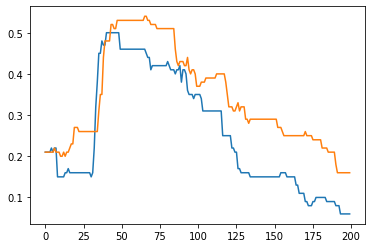

In [ ]:
# false positives with output probability
zz = [Pred[i] for i in FP_pred["FP_episodes_ID"]]
for cc in zz:
    plt.plot(cc)

# as you can see if we wait for more time steps the prediction will 
# be correct and we will not have any false positive in fact we do not 
# have any false positive after time step 80

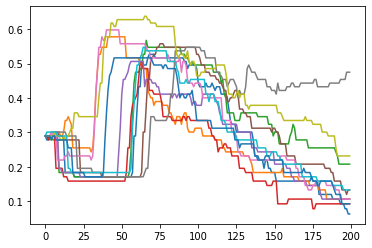

In [ ]:
# false positives with upper bound
zz = [UB[i] for i in FP_UB["FP_episodes_ID"]]
for cc in zz:
    plt.plot(cc)